# Object Detection using GluonCV on Amazon SageMaker

1. [Introduction](#Introduction)
2. [Setup](#Setup)
3. [Data Preparation](#Data-Preparation)
4. [Train the model](#Train-the-model)
5. [Host the model](#Host-the-model)
6. [Test the model](#Test-the-model)
7. [Clean up](#Clean-up)
8. [Improve the model](#Improve-the-model)
9. [Final cleanup](#Final-cleanup)

## Introduction

Object detection is the process of identifying and localizing objects in an image. A typical object detection solution takes an image as input and provides a bounding box on the image where an object of interest is found.  It also identifies what type of object the box encapsulates.  To create such a solution, we need to acquire and process a traning dataset, create and setup a training job for the alorithm so that it can learn about the dataset. Finally, we can then host the trained model in an endpoint, to which we can supply images.

This notebook is an end-to-end example showing how the Amazon SageMaker Object Detection algorithm can be used with a publicly available dataset of bird images. We demonstrate how to train and to host an object detection model based on the [Caltech Birds (CUB 200 2011)](http://www.vision.caltech.edu/visipedia/CUB-200-2011.html) dataset.  Amazon SageMaker's object detection algorithm uses the Single Shot multibox Detector ([SSD](https://arxiv.org/abs/1512.02325)) algorithm, and this notebook uses a [ResNet](https://arxiv.org/pdf/1603.05027.pdf) base network with that algorithm.

![Sample results detecting a pair of goldfinch on a feeder](./goldfinch_detections.png)

We will also demonstrate how to construct a training dataset using the RecordIO format, as this is the format that the training job consumes.  This notebook is similar to the [Object Detection using the RecordIO format](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/object_detection_pascalvoc_coco/object_detection_recordio_format.ipynb) notebook, with the following key differences:

- We provide an example of how to translate bounding box specifications when providing images to SageMaker's algorithm. You will see code for generating the train.lst and val.lst files used to create [recordIO](https://mxnet.incubator.apache.org/architecture/note_data_loading.html) files.
- We demonstrate how to improve an object detection model by adding training images that are flipped horizontally (mirror images).
- We give you a notebook for experimenting with object detection challenges with an order of magnitude more classes (200 bird species, as opposed to the 20 categories used by [Pascal VOC](http://host.robots.ox.ac.uk/pascal/VOC/)).
- We show how to chart the accuracy improvements that occur across the epochs of the training job.

Note that Amazon SageMaker Object Detection also allows training with the image and JSON format, which is illustrated in the [image and JSON Notebook](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/object_detection_pascalvoc_coco/object_detection_image_json_format.ipynb).

TODO--modify

## Setup

Before preparing the data, there are some initial steps required for setup.

First, you should be running this notebook on a **ml.c5d.4xlarge** or larger instance if you plan to run the training script locally on your notebook. Otherwise, you'll need to lower the batch size to avoid out-of-memory errors.

Any GPU instances like the ml.p3.2xlarge will do, and in practice, will be the ideal choice for a notebook instance.

Run the following cell to import the depedencies on this notebook. Most of the libraries that you need for MXNet and Gluon development are already packaged into the conda_mxnet_p36 environment.

In [1]:
import os
import time
import numpy as np
import pandas as pd
import mxnet as mx
from mxnet import autograd, gluon
from matplotlib import pyplot as plt
import sagemaker

role = sagemaker.get_execution_role()

GluonCV isn't pre-installed into this environment. However, most of the dependencies required by GluonCV have already been packaged into the **conda_mxnet_p36** environment. 

GluonCV has the following requirements that we will have to install manually:
* MXNet 1.4
* GluonCV libraries

Installation instructions for GluonCV are provided [here](https://gluon-cv.mxnet.io/#installation)

In [3]:
# MXNet has different libraries for GPU versus CPU environments. 
# We need to detect whether GPU is available on this instance.
USE_GPU = True
try:
    a = mx.nd.zeros((1,), ctx=mx.gpu(0))
    ctx = [mx.gpu(0)]
    print('GPU device is available')
except:
    ctx = [mx.cpu()]
    USE_GPU = False
    print('Using CPU on local machine. GPU device was not detected')

Using CPU on local machine. GPU device was not detected


Next we..
* Ensure pip is up to date.
* Upgrade MXNet 1.3 to 1.4 with the appropriate libraries depending on whether GPU is available.
* Install GluonCV

In [4]:
start = time.time()
os.system('pip install --upgrade pip')

if USE_GPU :
    os.system('pip install mxnet-cu90mkl>=1.4.0 --upgrade')
else :
    os.system('pip install mxnet-mkl>=1.4.0 --upgrade')

os.system('pip install gluoncv --upgrade')

end = time.time()

print("GluonCV dependencies were installed in {:3f} seconds.".format(end-start))

GluonCV dependencies were installed in 9.184580 seconds.


Gluoncv should now be available for us. Import our required libraries.

In [5]:
import gluoncv as gcv
from gluoncv.utils import download, viz

In the next session, we'll create an optimized dataset (RecordIO format) for training our YOLOv3 model. The process can take 15 minutes. 

It's up to you whether you like to go through the steps of pre-processing your dataset into RecordIO format. Alternatively, I've provided pre-processed datasets for you to use.

Run the cell below to set the locations of the pre-processed train and validation datasets. Note that MXNet doesn't require RecordIO format, but there are various benefits as described below.

In [6]:
SAMPLE_TRAINING_DATASET = 's3://reinvent2018-sagemaker-pytorch/datasets/caltech-birds/recordio/train'
SAMPLE_TEST_DATASET = 's3://reinvent2018-sagemaker-pytorch/datasets/caltech-birds/recordio/test'

# [Optional] Data Preparation and Exploration

---
This section is **optional**. For the purpose of making this lab as efficient as possible, data sets have already been prepared for you in MXNet [RecordIO format](https://mxnet.incubator.apache.org/versions/master/faq/recordio.html), which has various [benefits](https://mxnet.incubator.apache.org/versions/master/faq/recordio.html) including performance enhancements. The following are steps that were taken to produce training and validation samples in RecordIO format. Take note of the utility functions that MXNet provides for format conversion as well as the native data loaders. These are great features that reduce data wrangling work, and aren't provided by most frameworks.

---
This [link](https://cv-workshop-2.notebook.us-west-2.sagemaker.aws/notebooks/aws-cv-jumpstarter/notebooks/lab3b-optional-generate-recordio-files.ipynb) will launch another notebook, which will guide you through this optional section.

# Experimentation and Prototyping

The notebook environment is an ideal environment for rapid prototyping and experimentation. Run the cell below to preview the YOLOv3 training script that we will use to train the model.

The script is no different than one you would run outside of the Amazon SageMaker environment. The only exception is that are conditions in the script to set parameters to environment variables that will be present when we run remote SageMaker training. They're only necessary if you plan to refactor your script to take advantage of the zero-setup SageMaker training capabilities.

In [9]:
!pygmentize ../scripts/gluoncv_yolo3-train.py

import argparse
import os
#from os import walk
#import shutil
import logging
import time
#import json
import warnings
import numpy as np
import mxnet as mx
import pandas as pd
from mxnet import nd
from mxnet import gluon
from mxnet import autograd
import gluoncv as gcv
from gluoncv import data as gdata
from gluoncv import utils as gutils
from gluoncv.model_zoo import get_model
from gluoncv.data.batchify import Tuple, Stack, Pad
from gluoncv.data.transforms.presets.yolo import YOLO3DefaultTrainTransform
from gluoncv.data.transforms.presets.yolo import YOLO3DefaultValTransform
from gluoncv.data.dataloader import RandomTransformDataLoader
from gluoncv.utils.metrics.voc_detection import VOC07MApMetric
from gluoncv.utils.metrics.coco_detection import COCODetectionMetric
from gluoncv.utils import LRScheduler, LRSequential

EVAL_METRICS = {
    'mAP':0.0,
    'ObjLoss':10000.0,
    'BoxCenterLoss':10000.0,
    'BoxScaleLoss':10000.0,
    'ClassLoss':10000.0
}

MODEL_DIR = ""
CLASSES_FILE = ""

The command below runs the above script on this notebook. The script is only configure to run for one epoch because it can take over 5 minutes to run a single epoch on CPU.

The YOLOv3 script has been configured to use mobilenet1.0 (versus darknet), and will be initialized with weights pretrained on the VOC dataset.

It's **optional** to run this script locally.

In [10]:
!mkdir ./models
!python ../scripts/gluoncv_yolo3-train.py \
--model-dir ./models \
--train ./data/train \
--test ./data/test \
--lr 0.001 \
--opt adam \
--local True \
--pre-trained-weights VOC \
--network mobilenet1.0 --syncbn True --batch-size 16 --epochs 1

python: can't open file '../scripts/gluoncv_yolo3-sagemaker.py': [Errno 2] No such file or directory


In [11]:
import shutil

INSTANCE_GPUS = {
    'ml.p3.2xlarge':1,
    'ml.p3.8xlarge':4,
    'ml.c5.4xlarge':0,
    'ml.c5.xlarge':0
}

def set_requirements_text(gpu_train=True) :
    
    if gpu_train :
        shutil.copy('../scripts/requirements-gpu.txt','../scripts/requirements.txt')
    else :
        shutil.copy('../scripts/requirements-cpu.txt','../scripts/requirements.txt')

    !pygmentize ../scripts/requirements.txt

def environment_device_config(instance_selection) :
    
    GPU_TRAIN = INSTANCE_GPUS[instance_selection] > 0

    gpu_devices = '0'
    for i in range(1,INSTANCE_GPUS[instance_selection]) :
        gpu_devices+= ","+str(i)

    print('Set requirements.txt for {}:'.format('GPU' if GPU_TRAIN else 'CPU')) 
    print('-----------------------------------')
    set_requirements_text(GPU_TRAIN)
    print('-----------------------------------')
    
    config={
        "gpu_devices":gpu_devices,
        "batch_size_range": [13*INSTANCE_GPUS[instance_selection] if GPU_TRAIN else 16,
                          16*INSTANCE_GPUS[instance_selection] if GPU_TRAIN else 32]
    }
    
    print('You have selected {}, which will utilize {}.'.format(instance_selection, 'GPU' if GPU_TRAIN else 'CPU'))
    print('Recommended GPU dependent configurations: {}'.format(config))
    
    return config
      
config = environment_device_config('ml.p3.2xlarge')

Set requirements.txt for GPU:
-----------------------------------
pandas
mxnet-cu90mkl>=1.4.0
gluoncv
-----------------------------------
You have selected ml.p3.2xlarge, which will utilize GPU.
Recommended GPU dependent configurations: {'gpu_devices': '0', 'batch_size_range': [13, 16]}


In [12]:
params = {
    'optimizer': 'adam',
    'lr': 0.0001,
    'epochs': 1,
    'batch-size': config['batch_size_range'][1],
    'network':'mobilenet1.0',
    'syncbn':True,
    'pre-trained-weights':"VOC"} 
print(params)

{'optimizer': 'adam', 'lr': 0.0001, 'epochs': 1, 'batch-size': 16, 'network': 'mobilenet1.0', 'syncbn': True, 'pre-trained-weights': 'VOC'}


In [8]:
LOCAL_TRAINING_DATA_DIR = os.path.join(os.getcwd(),'data/train')
LOCAL_TEST_DATA_DIR = os.path.join(os.getcwd(),'data/test')
os.system('mkdir {}'.format(LOCAL_TRAINING_DATA_DIR))
os.system('mkdir {}'.format(LOCAL_TEST_DATA_DIR))

start=time.time()
os.system('aws s3 sync {} {}'.format(SAMPLE_TRAINING_DATASET,LOCAL_TRAINING_DATA_DIR))
os.system('aws s3 sync {} {}'.format(SAMPLE_TEST_DATASET,LOCAL_TEST_DATA_DIR))
end=time.time()

print('Data set was downloaded in {} seconds.'.format(end-start))

Data set was downloaded in 1.6072466373443604 seconds.


In [13]:
from sagemaker.mxnet import MXNet

BASE_JOB_NAME ='dtong-yolo3-local-training'
#BASE_JOB_NAME='<<NAME YOUR TRAINING JOB>>'
SOURCE_DIR = '../scripts'

local_estimator = MXNet(entry_point='gluoncv_yolo3-sagemaker.py',
                       role=role,
                       source_dir=SOURCE_DIR,
                       framework_version='1.3.0',
                       py_version='py3',
                       train_instance_count=1,
                       train_instance_type='local',
                       base_job_name=BASE_JOB_NAME,
                       hyperparameters=params)

In [26]:
local_estimator.fit({'train': 'file://'+LOCAL_TRAINING_DATA_DIR, 
                    'test': 'file://'+LOCAL_TEST_DATA_DIR})
#local_estimator.fit({'train': SAMPLE_TRAINING_DATASET, 
#                    'test': SAMPLE_TEST_DATASET})

Creating tmp2vyc9obw_algo-1-c3yh6_1 ... 
Attaching to tmp2vyc9obw_algo-1-c3yh6_12mdone
algo-1-c3yh6_1  | 2019-05-16 17:08:37,956 sagemaker-containers INFO     Imported framework sagemaker_mxnet_container.training
algo-1-c3yh6_1  | 2019-05-16 17:08:37,959 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-c3yh6_1  | 2019-05-16 17:08:37,973 sagemaker_mxnet_container.training INFO     MXNet training environment: {'SM_CHANNELS': '["test","train"]', 'SM_USER_ARGS': '["--batch-size","16","--epochs","1","--lr","0.0001","--network","mobilenet1.0","--optimizer","adam","--pre-trained-weights","VOC","--syncbn","True"]', 'SM_INPUT_CONFIG_DIR': '/opt/ml/input/config', 'SM_MODEL_DIR': '/opt/ml/model', 'SM_RESOURCE_CONFIG': '{"current_host":"algo-1-c3yh6","hosts":["algo-1-c3yh6"]}', 'SM_NUM_GPUS': '0', 'SM_LOG_LEVEL': '20', 'SM_HP_LR': '0.0001', 'SM_FRAMEWORK_PARAMS': '{}', 'SM_OUTPUT_DATA_DIR': '/opt/ml/output/data', 'SM_HP_EPOCHS': '1', 'SM_HP_OPTIMIZER': 'adam', 'S

KeyboardInterrupt: 

# Train the model

Once you've identified candidate algorithm(s) and an architecture that is ready for larger scale training, you can greatly reduce the heavy-lift by utilizing Amazon SageMaker training capabilities.

## Step 1: Define your hyperparameters

After you've verified that your script runs on Amazon SageMaker training without errors, a good first step is utilize the SageMaker's Automatic Model Tuning to hone in a good set of hyperparameters.

The environment as well as certain hyperparameters are dependent on the amount of available GPU. We need to ensure the right libraries are installed if you select a GPU enabled instance. Secondly, if you have multiple GPUs either on a single instance or distributed cluster, you have more GPU memory available to support larger batch sizes for accelerating training time. In this case, the YOLOv3 script also needs to know how many devices you like to use for multiple GPU training on a single instance, so that data sharding can be implemented to support data parallelism.

Be warn that you may need to compensate for model performance degradation as a result of training on large batch sizes by lowering the learning rate.

In [22]:
INSTANCE_SELECTION = 'ml.p3.8xlarge'
INSTANCE_GPUS = {
    'ml.p3.2xlarge':1,
    'ml.p3.8xlarge':4,
    'ml.c5.4xlarge':0
}

GPU_TRAIN = INSTANCE_GPUS[INSTANCE_SELECTION] > 0

devices = '0'
for i in range(1,INSTANCE_GPUS[INSTANCE_SELECTION]) :
    devices+= ","+str(i)

batch_size_l = 13*INSTANCE_GPUS[INSTANCE_SELECTION] if GPU_TRAIN else 16
batch_size_h = 16*INSTANCE_GPUS[INSTANCE_SELECTION] if GPU_TRAIN else 32

print('You have selected {}, which will utilize {}.'.format(INSTANCE_SELECTION, 'GPU' if GPU_TRAIN else 'CPU'))
print('{} has {} GPUs, so we will use batch sizes in the range of {} to {}.'
      .format(INSTANCE_SELECTION,
             INSTANCE_GPUS[INSTANCE_SELECTION],
             batch_size_l,
             batch_size_h))

You have selected ml.p3.8xlarge, which will utilize GPU.
ml.p3.8xlarge has 4 GPUs, so we will use batch sizes in the range of 52 to 64.


Next, we need to specify the objective metric so that SageMaker can use Bayesian Optimization to find hyperparameters that optimize on a specific objective. We'll use the standard objective, which is to maximize mAP on the validation set.

The regex experession informs SageMaker how to parse the logs to obtain the configured objective metric. The expectation is that your script writes out the objective metric into the logs.

In [31]:
OBJECTIVE_METRIC_NAME = 'mAP'
OBJECTIVE_TYPE = 'Maximize'

METRIC_DEFINITIONS = [{ 'Name':OBJECTIVE_METRIC_NAME,
                        'Regex':'Target Objective: {} = ([0-9\\.]+)'.format(OBJECTIVE_METRIC_NAME)}]

print(METRIC_DEFINITIONS)

[{'Name': 'mAP', 'Regex': 'Target Objective: mAP = ([0-9\\.]+)'}]


Next, we set the hyperparameters as well as the the hyperparameter value ranges that you want Amazon SageMaker to search over.

The configurations below will search for optimal values for the optimizer to use, the learning rate, and the mini-batch-size. In practice, you might want to explore other variables such as the base network, pretrained weights, and other variables that could influence the performance of your model.

In [43]:
HYPERPARAMETER_RANGES = {'opt': CategoricalParameter(['adam','sgd']),
                         'lr': ContinuousParameter(0.0002, 0.001, scaling_type='Logarithmic'),
                         'batch_size': IntegerParameter(batch_size_l, batch_size_h)}

params = {
    'opt': 'adam',
    'epochs': 5,
    'network':'mobilenet1.0',
    'syncbn':True,
    'gpus': devices } 

print(params)

{'opt': 'adam', 'epochs': 5, 'network': 'mobilenet1.0', 'syncbn': True, 'gpus': '0'}


One of the main benefits of the BYOS integration is that there isn't a heavy-lift involved in integration. For instance, if you want to integrate a custom algorithm in R with Amazon SageMaker, it is feasible. However, at this point in time, the BYOS integration path isn't supported in R. Integrating your R algorithm would require you to build Amazon SageMaker compatible containers to house your custom [algorithm](https://docs.aws.amazon.com/sagemaker/latest/dg/your-algorithms.html).

MXNet, however, supports the BYOS integration. Therefore, SageMaker provides containers natively. The one catch is that Amazon SageMaker currently supports containers for MXNet 1.3 and lower. GluonCV requires MXNet 1.4. However, we can still avoid building our own containers by leveraging the MXNet 1.3 SageMaker container.

This involves providing a requirements.txt file along with your scripts to provide Amazon SageMaker training instructions on how to update the MXNet1.3 container on launch.

Since the dependencies are dependent on GPU availability, I've provided two variations of requirements.txt for our GluonCV YOLOv3 algorithm.

---
Run the cell below to preview the dependencies required for GPU enabled training instances.

In [25]:
!pygmentize ../scripts/requirements-gpu.txt

pandas
mxnet-cu90mkl>=1.4.0
gluoncv


Run the cell below to preview the dependencies required for training instances that don't have GPU available.

In [26]:
!pygmentize ../scripts/requirements-cpu.txt

pandas
mxnet-mkl>=1.4.0
gluoncv


Now let's create the right requirements.txt file depending on which training instance you've selected.

In [27]:
import shutil
if GPU_TRAIN :
    shutil.copy('../scripts/requirements-gpu.txt','../scripts/requirements.txt')
else :
    shutil.copy('../scripts/requirements-cpu.txt','../scripts/requirements.txt')
    
!pygmentize ../scripts/requirements.txt

pandas
mxnet-cu90mkl>=1.4.0
gluoncv


## Step 2: Launch your Hyperparameter Tuning Job

Similar to Lab 2, we're going to launch an hyperparamter job to automate the hyperparameter search process. The difference is that we're launching this job programatically via the Python SDK. 

Secondly, since we're training on a custom script, we have a couple of additional parameters: (1) we specify the location of the scripts in our local directory (source_dir) (2) we provide the name of our MXNet (GluonCV) script that serves as an entry point (entry_point) for our algorithm. 

Lastly, we have provided a requirements.txt file in the same directory as our scripts, so that it will be loaded into our training containers. Requirements.txt will instruct SageMaker to install the necessary dependencies on to the training containers upon launch. The values framework_version='1.3.0' and py_version='py3' informs SageMaker to use the MXNet container that has been pre-built and tested for MXNet1.3 running on python3.

Replace '\<<NAME YOUR HPO JOB\>>' with a unique name, so that you can identify your hyperparameter tuning jobs.

In this cell we instantiate an MXNet estimator. This object ecapsulates your MXNet algorithm including infrastructure configurations that it will leverage when you execute training via the fit() method.

In [29]:
import sagemaker
from sagemaker.mxnet import MXNet
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

role = sagemaker.get_execution_role()

#BASE_JOB_NAME='dtong-yolo3-hpo'
BASE_JOB_NAME='<<NAME YOUR HPO JOB>>'
SOURCE_DIR = '../scripts'

estimator = MXNet(entry_point='gluoncv_yolo3-sagemaker.py',
                  role=role,
                  source_dir=SOURCE_DIR,
                  framework_version='1.3.0',
                  py_version='py3',
                  train_instance_count=1,
                  train_instance_type=INSTANCE_SELECTION,
                  sagemaker_session=sagemaker.Session(),
                  base_job_name=BASE_JOB_NAME,
                  hyperparameters=params)

Next, we configure the parameters for our automatic hyperparameter tuner job. We provide the same parameters as we did in Lab 2 except we're instantiating the job programmatically via the SDK. Note that we only run two jobs (max_jobs=2) for the sake of demonstration. In practice, you'll need to run more to hone in on optimal parameters.

In [32]:
tuner = HyperparameterTuner(estimator,
                            OBJECTIVE_METRIC_NAME,
                            HYPERPARAMETER_RANGES,
                            METRIC_DEFINITIONS,
                            objective_type = OBJECTIVE_TYPE,
                            max_jobs=2,
                            max_parallel_jobs=1)

Calling fit() on our tuner launch the job as a non-blocking asynchronous call. We pass two parameters to specify the location of our training and test sets.

'Train' and 'Test' will be treated as "channels" and the training container will have environment variables with the name SM_CHANNEL_TRAIN and SM_CHANNEL_TEST created respectively. The datasets will be loaded from the specified S3 location, and can be access in the training container context via the environment variables (eg. os.environ['SM_CHANNEL_TRAIN'])

In [27]:
tuner.fit({'train': SAMPLE_TRAINING_DATASET, 
           'test': SAMPLE_TEST_DATASET})

NameError: name 'tuner' is not defined

## Step 3: Finetune your model

The training process will be iterative as described in Lab 2. Eventually, you will hone in on a set of parameters, and may choose to further fine tune the model.

The section below demonstrates how to perform incremental training on a model that you've previously trained. For instance, this could be the best model from your recent Hyperparameter Tuning Job. 

The training time required to train a YOLOv3 model is beyond what is practical for a workshop. Therefore, I've provided a pretrained YOLOv3 model that has been finetuned a sample of our CalTech Birds dataset. You can treat this model as if it were the output of your Hyperparameter Tuning Job.

In [29]:
TRAINED_MODEL = 'yolo3_mobilenet1.0_custom_best.params'
TRAINED_MODEL_URI = 's3://reinvent2018-sagemaker-pytorch/models/caltech-birds/gluoncv/yolov3/sample/{}'.format(TRAINED_MODEL)

Let's select an instance and rest our parameters. We'll use a smaller GPU instance for the purpose of minimizing the cost of this lab.

Note that we've also set the epochs to one for the sake of demonstration. The provided model has been trained for hundreds of epochs.

In [28]:
INSTANCE_SELECTION = 'ml.p3.2xlarge'
INSTANCE_GPUS = {
    'ml.p3.2xlarge':1,
    'ml.p3.8xlarge':4,
    'ml.c5.4xlarge':0
}

GPU_TRAIN = INSTANCE_GPUS[INSTANCE_SELECTION] > 0

devices = '0'
for i in range(1,INSTANCE_GPUS[INSTANCE_SELECTION]) :
    devices+= ","+str(i)

params = {
    'optimizer': 'adam',
    'lr': 0.0001,
    'epochs': 1,
    'batch-size': 16*INSTANCE_GPUS[INSTANCE_SELECTION] if GPU_TRAIN else 32,
    'network':'mobilenet1.0',
    'syncbn':True,
    'pre-trained-weights':"NONE",
    'resume': TRAINED_MODEL,
    'gpus': devices } 
print(params)

{'optimizer': 'adam', 'lr': 0.0001, 'epochs': 1, 'batch-size': 16, 'network': 'mobilenet1.0', 'syncbn': True, 'pre-trained-weights': 'NONE', 'resume': 'yolo3_mobilenet1.0_custom_best.params', 'gpus': '0'}


Replace '\<<NAME YOUR TRAINING JOB\>>' with an unique prefix that will help you identify your training job.

We're going to instantiate another MXNet estimator object. The main difference is the "model_uri" parameter, which will result in having the model artifacts at the specified S3 location to be uploaded into the training container. Your script can then initialize a model with those weights. The artifacts are located in the directory specified by the SM_CHANNEL_MODEL environment variable.

In [30]:
BASE_JOB_NAME ='dtong-yolo3-incremental-training'
#BASE_JOB_NAME='<<NAME YOUR TRAINING JOB>>'
SOURCE_DIR = '../scripts'

incr_estimator = MXNet(entry_point='gluoncv_yolo3-sagemaker.py',
                       role=role,
                       source_dir=SOURCE_DIR,
                       framework_version='1.3.0',
                       py_version='py3',
                       train_instance_count=1,
                       train_instance_type=INSTANCE_SELECTION,
                       sagemaker_session=sagemaker.Session(),
                       base_job_name=BASE_JOB_NAME,
                       hyperparameters=params,
                       model_uri=TRAINED_MODEL_URI)

In [31]:
incr_estimator.fit({'train': SAMPLE_TRAINING_DATASET, 
                    'test': SAMPLE_TEST_DATASET})

2019-05-16 17:09:09 Starting - Starting the training job...
2019-05-16 17:09:12 Starting - Launching requested ML instances.........
2019-05-16 17:10:44 Starting - Preparing the instances for training...
2019-05-16 17:11:39 Downloading - Downloading input data...
2019-05-16 17:11:51 Training - Downloading the training image..
2019-05-16 17:12:18,017 sagemaker-containers INFO     Imported framework sagemaker_mxnet_container.training
2019-05-16 17:12:18,045 sagemaker_mxnet_container.training INFO     MXNet training environment: {'SM_HP_NETWORK': 'mobilenet1.0', 'SM_HP_SYNCBN': 'true', 'SM_OUTPUT_DATA_DIR': '/opt/ml/output/data', 'SM_LOG_LEVEL': '20', 'SM_CHANNEL_MODEL': '/opt/ml/input/data/model', 'SM_HOSTS': '["algo-1"]', 'SM_RESOURCE_CONFIG': '{"current_host":"algo-1","hosts":["algo-1"],"network_interface_name":"ethwe"}', 'SM_OUTPUT_DIR': '/opt/ml/output', 'SM_HP_GPUS': '0', 'SM_INPUT_DIR': '/opt/ml/input', 'SM_CURRENT_HOST': 'algo-1', 'SM_HP_PRE-TRAINED-WEIGHTS': 'NONE', 'SM_HP_EPOCHS

      Successfully uninstalled mxnet-cu90mkl-1.3.0.post0
You are using pip version 18.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
2019-05-16 17:13:01,962 sagemaker-containers INFO     Invoking user script

Training Env:

{
    "master_hostname": "algo-1",
    "hosts": [
        "algo-1"
    ],
    "job_name": "dtong-yolo3-incremental-training-2019-05-16-17-09-07-448",
    "input_data_config": {
        "test": {
            "TrainingInputMode": "File",
            "RecordWrapperType": "None",
            "S3DistributionType": "FullyReplicated"
        },
        "model": {
            "RecordWrapperType": "None",
            "TrainingInputMode": "File",
            "ContentType": "application/x-sagemaker-model",
            "S3DistributionType": "FullyReplicated"
        },
        "train": {
            "TrainingInputMode": "File",
            "RecordWrapperType": "None",
            "S3DistributionType": "FullyRep


2019-05-16 17:13:38 Uploading - Uploading generated training modelINFO:root:[Epoch 0] Training cost: 6.758, ObjLoss=0.878, BoxCenterLoss=1.804, BoxScaleLoss=0.325, ClassLoss=0.297
[17:13:27] src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (setting env variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)
INFO:root:[Epoch 0] Validation: 
017.Cardinal=0.5454545454545455
036.Northern_Flicker=1.0000000000000002
047.American_Goldfinch=1.0000000000000002
068.Ruby_throated_Hummingbird=1.0000000000000002
073.Blue_Jay=1.0000000000000002
mAP=0.9090909090909092
INFO:root:Target Objective: mAP = 0.90909091
attempting walk in model_dir..
classes.params
model_info.params
yolo3_mobilenet1.0_custom_best.params
2019-05-16 17:13:33,884 sagemaker-containers INFO     Reporting training SUCCESS

2019-05-16 17:14:09 Completed - Training job completed
Billable seconds: 150


# Deploy your Model

An endpoint can be programatically deployed just by calling the deploy() method on our estimator after it has been trained (via fit()). 

Replace \'<<PROVIDE AN ENDPOINT NAME\>>' with an unique name so that you can identify your endpoint. For the purpose of demonstration, we only deply an single instance. However, the endpoint can be configured for auto-scaling and deployed across a fleet to support throughput requirements.

In [ ]:
INSTANCE_SELECTION = 'ml.c5.xlarge'
INSTANCE_GPUS = {
    'ml.p3.2xlarge':1,
    'ml.c5.xlarge':0
}

GPU_INFERENCE = INSTANCE_GPUS[INSTANCE_SELECTION] > 0




In [41]:
from sagemaker.mxnet import MXNetModel

model_location = 's3://sagemaker-us-west-2-803235869972/dtong-yolo3-incremental-training-2019-05-16-17-09-07-448/output/model.tar.gz'
code_location = '../scripts'

yolo_model = MXNetModel(model_data = model_location,
                        role=role,
                        framework_version="1.3",
                        py_version="py3",
                        entry_point='gluoncv-yolo3-inference.py',
                        env = {"SAGEMAKER_MODEL_SERVER_TIMEOUT":"3600"},
                        source_dir=code_location)

In [42]:
RT_ENDPOINT_NAME = 'dtong-yolov3-rt-ep-{}'.format(datetime.now().strftime('%Y-%m-%d-%H-%M-%S'))
print('endpoint name: {}'.format(RT_ENDPOINT_NAME))

yolo_rt_ep = yolo_model.deploy(instance_type='ml.p3.2xlarge',
                                initial_instance_count = 1,
                                endpoint_name= RT_ENDPOINT_NAME)

endpoint name: dtong-yolov3-rt-ep-2019-05-16-18-37-31
---------------------------------------------------------------------------------------------------------------!

In [44]:
!wget -q -O multi-goldfinch-1.jpg https://t3.ftcdn.net/jpg/01/44/64/36/500_F_144643697_GJRUBtGc55KYSMpyg1Kucb9yJzvMQooW.jpg
!wget -q -O northern-flicker-1.jpg https://upload.wikimedia.org/wikipedia/commons/5/5c/Northern_Flicker_%28Red-shafted%29.jpg
!wget -q -O northern-cardinal-1.jpg https://cdn.pixabay.com/photo/2013/03/19/04/42/bird-94957_960_720.jpg
!wget -q -O blue-jay-1.jpg https://cdn12.picryl.com/photo/2016/12/31/blue-jay-bird-feather-animals-b8ee04-1024.jpg
!wget -q -O hummingbird-1.jpg http://res.freestockphotos.biz/pictures/17/17875-hummingbird-close-up-pv.jpg

In [64]:
images = ['multi-goldfinch-1.jpg','northern-flicker-1.jpg', 
          'northern-cardinal-1.jpg','blue-jay-1.jpg','hummingbird-1.jpg']

filename = images[0]
with open(filename, 'rb') as image:
    f = image.read()
    b = bytearray(f)

nd_img = mx.img.imdecode(b)
print(nd_img.shape)

(334, 500, 3)


In [65]:
import boto3
runtime = boto3.client(service_name='runtime.sagemaker')

endpoint_response = runtime.invoke_endpoint(EndpointName=yolo_rt_ep.endpoint,
                                           ContentType='image/jpeg',
                                           Body=b)

In [61]:
stacked_tensors = np.frombuffer(endpoint_response['Body'].read(), dtype="float32")

In [62]:
stacked_tensors.shape

(600,)

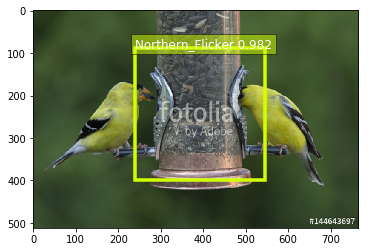

In [66]:
classes = ['Cardinal','Northern_Flicker','American_Goldfinch',
          'Ruby_throated_Hummingbird','Blue_Jay']

t= np.split(stacked_tensors,[100,200,600])

c= mx.nd.array(t[0].reshape(100,1))
s= mx.nd.array(t[1].reshape(100,1))
bb= mx.nd.array(t[2].reshape(100,4))

x, image = gcv.data.transforms.presets.yolo.transform_test(mx.img.imdecode(b), 512)

ax = viz.plot_bbox(image, bb, s,c, class_names=classes)
plt.show()

In [53]:
stacked_tensors = np.frombuffer(endpoint_response, dtype="float32")

{'ResponseMetadata': {'RequestId': '7a469a3d-5da0-454e-9801-4a127886cfde', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '7a469a3d-5da0-454e-9801-4a127886cfde', 'x-amzn-invoked-production-variant': 'AllTraffic', 'date': 'Thu, 16 May 2019 18:57:32 GMT', 'content-type': 'application/json', 'content-length': '2400'}, 'RetryAttempts': 0}, 'ContentType': 'application/json', 'InvokedProductionVariant': 'AllTraffic', 'Body': <botocore.response.StreamingBody object at 0x7f8cf44ff1d0>}


In [32]:
from datetime import datetime

start=time.time()

RT_ENDPOINT_NAME = 'dtong-yolov3-rt-ep-{}'.format(datetime.now().strftime('%Y-%m-%d-%H-%M-%S'))
#RT_ENDPOINT_NAME = '<<PROVIDE AN ENDPOINT NAME>>'
rt_inference_ep = incr_estimator.deploy(instance_type='ml.p3.2xlarge',
                                        initial_instance_count = 1,
                                        endpoint_name= RT_ENDPOINT_NAME)

end=time.time()

print('Your endpoint was deployed after {} seconds.'.format(end-start))

-----------------------------------------------------------------------------------------------------------------------------------------*

ValueError: Error hosting endpoint dtong-yolov3-rt-ep-2019-05-16-17-24-57: Failed Reason:  The primary container for production variant AllTraffic did not pass the ping health check. Please check CloudWatch logs for this endpoint.

# Visualize

In [ ]:
def visualize_detection(img_file, dets, classes=[], thresh=0.6):
        """
        visualize detections in one image
        Parameters:
        ----------
        img : numpy.array
            image, in bgr format
        dets : numpy.array
            ssd detections, numpy.array([[id, score, x1, y1, x2, y2]...])
            each row is one object
        classes : tuple or list of str
            class names
        thresh : float
            score threshold
        """
        import random
        import matplotlib.pyplot as plt
        import matplotlib.image as mpimg

        img = mpimg.imread(img_file)
        plt.imshow(img)
        height = img.shape[0]
        width  = img.shape[1]
        colors = dict()
        num_detections = 0
        for det in dets:
            (klass, score, x0, y0, x1, y1) = det
            if score < thresh:
                continue
            num_detections += 1
            cls_id = int(klass)
            if cls_id not in colors:
                colors[cls_id] = (random.random(), random.random(), random.random())
            xmin = int(x0 * width)
            ymin = int(y0 * height)
            xmax = int(x1 * width)
            ymax = int(y1 * height)
            rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False,
                                 edgecolor=colors[cls_id], linewidth=3.5)
            plt.gca().add_patch(rect)
            class_name = str(cls_id)
            if classes and len(classes) > cls_id:
                class_name = classes[cls_id]
            print('{},{}'.format(class_name,score))
            plt.gca().text(xmin, ymin - 2,
                            '{:s} {:.3f}'.format(class_name, score),
                            bbox=dict(facecolor=colors[cls_id], alpha=0.5),
                                    fontsize=12, color='white')

        print('Number of detections: ' + str(num_detections))
        plt.show()

In [ ]:
import boto3

OBJECT_CATEGORIES = ['Cardinal','Northern_Flicker','American_Goldfinch',
          'Ruby_throated_Hummingbird','Blue_Jay']

runtime = boto3.client(service_name='runtime.sagemaker')

def show_bird_prediction(filename, ep, thresh=0.40):
    b = ''
    with open(filename, 'rb') as image:
        f = image.read()
        b = bytearray(f)
    endpoint_response = runtime.invoke_endpoint(EndpointName=ep,
                                           ContentType='image/jpeg',
                                           Body=b)
    results = endpoint_response['Body'].read()
    detections = json.loads(results)
    visualize_detection(filename, detections['prediction'], OBJECT_CATEGORIES, thresh)

In [ ]:
def test_model(object_detector):
    show_bird_prediction('hummingbird-1.jpg', object_detector.endpoint)
    show_bird_prediction('blue-jay-1.jpg', object_detector.endpoint)
    show_bird_prediction('multi-goldfinch-1.jpg', object_detector.endpoint)
    show_bird_prediction('northern-flicker-1.jpg', object_detector.endpoint)
    show_bird_prediction('northern-cardinal-1.jpg', object_detector.endpoint)

test_model(rt_inference_ep)

In [ ]:
import time
from matplotlib import pyplot as plt
import numpy as np
import mxnet as mx
from mxnet import autograd, gluon
import gluoncv as gcv
from gluoncv.utils import download, viz

images = ['multi-goldfinch-1.jpg','northern-flicker-1.jpg', 
          'northern-cardinal-1.jpg','blue-jay-1.jpg','hummingbird-1.jpg']

classes = ['Cardinal','Northern_Flicker','American_Goldfinch',
          'Ruby_throated_Hummingbird','Blue_Jay']
    
net = gcv.model_zoo.get_model('yolo3_mobilenet1.0_custom', classes=classes, pretrained_base=False)
net.load_parameters('../models/pretrained/model.params')
x, image = gcv.data.transforms.presets.yolo.load_test(images[0], 512)
cid, score, bbox = net(x)
ax = viz.plot_bbox(image, bbox[0], score[0], cid[0], class_names=net.classes)
plt.show()

Next we define an output location in S3, where the model artifacts will be placed on completion of the training. These artifacts are the output of the algorithm's traning job.  We also get the URI to the Amazon SageMaker Object Detection docker image.  This ensures the estimator uses the correct algorithm from the current region.

Now that the training job is complete, you can also see the job listed in the `Training jobs` section of your SageMaker console.  Note that the job name is uniquely identified by the name of the algorithm concatenated with the date and time stamp.  You can click on the job to see the details including the hyperparameters, the data channel definitions, and the full path to the resulting model artifacts.  You could even clone the job from the console, and tweak some of the parameters to generate a new training job.

Now we use our endpoint to try to detect objects within an image. Since the image is a jpeg, we use the appropriate content_type to run the prediction. The endpoint returns a JSON object that we can simply load and peek into. We have packaged the prediction code into a function to make it easier to test other images.  Note that we are defaulting the confidence threshold to 30% in our example, as a couple of the birds in our sample images were not being detected as clearly.  Defining an appropriate threshold is entirely dependent on your use case.

# Clean up
Here we delete the SageMaker endpoint, as we will no longer be performing any inferences.  This is an important step, as your account is billed for the amount of time an endpoint is running, even when it is idle.

In [ ]:
sagemaker.Session().delete_endpoint(object_detector.endpoint)

## Re-deploy and test

In [ ]:
# host the updated model
object_detector = od_model.deploy(initial_instance_count = 1, instance_type = 'ml.m4.xlarge')

# test the new model
test_model()

## Final cleanup
Here we delete the SageMaker endpoint, as we will no longer be performing any inferences.  This is an important step, as your account is billed for the amount of time an endpoint is running, even when it is idle.

In [ ]:
# delete the new endpoint
sagemaker.Session().delete_endpoint(object_detector.endpoint)